Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [10]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'originated', 'term', 'term', 'of', 'as', 'originated']


Train a skip-gram model.

In [61]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

# Words used for the testing:
word_1="paris"
word_2="france"
word_3="italy"
exp_word="rome"

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  
  print(valid_embeddings.get_shape())
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  
  def word_relation_test():
    emb1=tf.nn.embedding_lookup(normalized_embeddings,count[dictionary[word_1]][1])
    emb2=tf.nn.embedding_lookup(normalized_embeddings,count[dictionary[word_2]][1])
    emb3=tf.nn.embedding_lookup(normalized_embeddings,count[dictionary[word_3]][1])
    
    emb4 = emb1-emb2+emb3
    
    emb4 = tf.expand_dims(emb4,1) # to make the embedding a matrix as it's required by MatMul
    print(emb4.get_shape())
    return tf.transpose(emb4)
    
  test_relations = tf.matmul(word_relation_test(),tf.transpose(normalized_embeddings))



(16, 128)
(128, 1)


In [81]:
num_steps = 100001
#num_steps = 11

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
     
  #testing the word relationships
  test_k=5
  test=test_relations.eval()
  nearest = (-test[0][:]).argsort()[1:test_k+1]
  
  possible_answers=[]
  for k in range(test_k):
        possible_answers.append(reverse_dictionary[nearest[k]])
        
  log = 'Paris - France + Rome = %s,' % (possible_answers)
  print(log)
    
     
    
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.379778
Nearest to system: grammy, pierre, ebcdic, peninsula, derogatory, hasidism, interrupts, kapellmeister,
Nearest to five: promulgated, glance, fastest, facilitator, cordon, usability, believers, abbasids,
Nearest to there: marmara, hesychasm, bessarabia, mahmud, vega, eschewing, interruptions, pontiff,
Nearest to world: christiania, keller, chunk, janissaries, burmese, end, eject, reagan,
Nearest to war: restyled, stadler, ligature, incubus, unusually, additional, instincts, mitre,
Nearest to these: catchphrase, wakizashi, articles, unimaginable, itis, antiprism, valuable, handover,
Nearest to on: lunches, personifications, sta, acad, alioth, leningrad, khalil, sarti,
Nearest to however: crowned, observed, printable, sahib, cubs, twas, strau, ergaster,
Nearest to about: sosa, escorial, manga, wildstorm, organically, tag, brahmin, ean,
Nearest to often: penance, anchor, mcluhan, unionist, differing, deepening, nearer, mistletoe,
Nearest to d: a

In [ ]:
#num_points = 400
num_points = 50000

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [ ]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [43]:
# Semantic-Syntactic Word Relationship test
#“Paris - France + Italy = ???”, “bigger - big + small = ???”

#print(final_embeddings[0])
#print(data[0])
#print(reverse_dictionary[5239])
#print(dictionary["paris"])
#print(count[5239])
#print(count[dictionary["france"]][1])

paris_emb=final_embeddings[count[dictionary["paris"]][1]]
france_emb=final_embeddings[count[dictionary["france"]][1]]
italy_emd=final_embeddings[count[dictionary["italy"]][1]]

#print(paris_emb-france_emb+italy_emd)
print(valid_dataset[2])
print(count[dictionary["paris"]][1])

Tensor("strided_slice:0", shape=(), dtype=int32)
1699


---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [6]:
# A method to build batch for training CBOW model
def generate_batch_cbow(data, batch_size, num_skips, skip_window):
    """
    Batch generator for CBOW (Continuous Bag of Words).
	batch should be a shape of (batch_size, num_skips)
	Parameters
	----------
	data: list of index of words
	batch_size: number of words in each mini-batch
	num_skips: number of surrounding words on both direction (2: one word ahead and one word following)
	skip_window: number of words at both ends of a sentence to skip (1: skip the first and last word of a sentence)
	"""
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # used for collecting data[data_index] in the sliding window
    # collect the first window of words
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # move the sliding window
    for i in range(batch_size):
        mask = [1] * span
        mask[skip_window] = 0
        batch[i, :] = list(np.compress(mask, buffer))  # all surrounding words. VD: swap the arguments
        labels[i, 0] = buffer[skip_window]  # the word at the center
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


Initialized
Average loss at step  0 :  309.738952637
Nearest to of: provide, ore, baryonic, disillusionment, appointing, aiki, edmund, restraint,
Nearest to been: verified, autodesk, database, hmso, asterisk, tempting, motive, interquartile,
Nearest to had: undecided, blackboard, kummer, georgy, separating, hunters, hort, ambassador,
Nearest to many: ole, cond, mechanism, bollywood, persia, governorates, successive, yangon,
Nearest to a: astrologically, orbs, modulator, balance, derogatory, amassing, outbreaks, vied,
Nearest to some: igneous, sensed, barriers, suit, lebowski, tubular, dodgers, sliding,
Nearest to often: cuneiform, ghost, firestorm, codenamed, encroachment, lisboa, latvian, hum,
Nearest to was: marjoram, vendetta, sleek, sacrum, tapered, garnering, dissociatives, philipp,
Nearest to so: ruth, canmore, harness, caring, discreetly, cameo, dungeon, dix,
Nearest to these: cotten, assimilated, plausibly, madame, appian, manufacturers, pogroms, interactive,
Nearest to be: dem

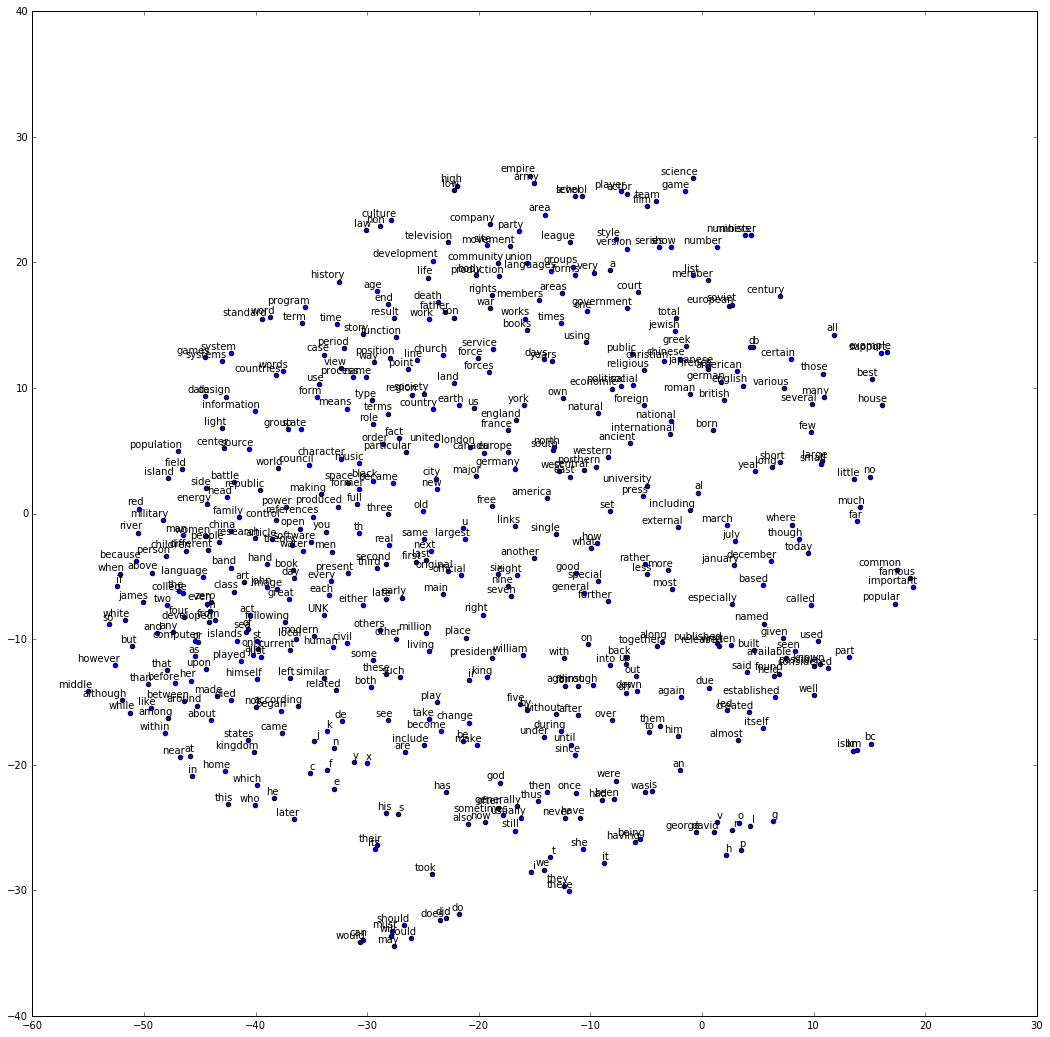

In [8]:
# Step 4: Build and train a CBOW model.
data_index = 0

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.

    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)


    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


        embed = tf.zeros([batch_size, embedding_size])
        for j in range(num_skips):
            embed += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [10]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):

        batch_inputs, batch_labels = generate_batch_cbow(data, batch_size=batch_size, num_skips=num_skips,
                                                skip_window=skip_window)
        feed_dict = {train_dataset: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  314.850219727
Nearest to of: bucket, waid, burroughs, hor, oa, cabot, readable, myr,
Nearest to been: weekends, malan, excellent, clovis, abernathy, mangaverse, bicoid, url,
Nearest to had: edmunds, galactus, mundane, cbm, bastille, pitt, gonzo, celebrity,
Nearest to many: mckenzie, bendix, dormant, bavaria, fsln, detectors, hinges, ashore,
Nearest to a: polytechnic, champ, buns, bornholm, novo, pikemen, amoxicillin, rigidly,
Nearest to some: beavis, denizens, yakovlev, hatta, plagioclase, citations, disco, brut,
Nearest to often: vows, physiologic, amiable, somber, fleece, mellor, freshmen, greeneville,
Nearest to was: italo, topaz, accountant, targets, ordinated, list, radiant, beltane,
Nearest to so: breisgau, gesenius, celebrities, sampled, condoned, moser, lensing, thursdays,
Nearest to these: sparingly, continuing, thz, mongoloid, pdf, mistake, kk, entrances,
Nearest to be: eastwards, moynihan, haddo, bin, lieutenant, fiefs, firewall, deserv

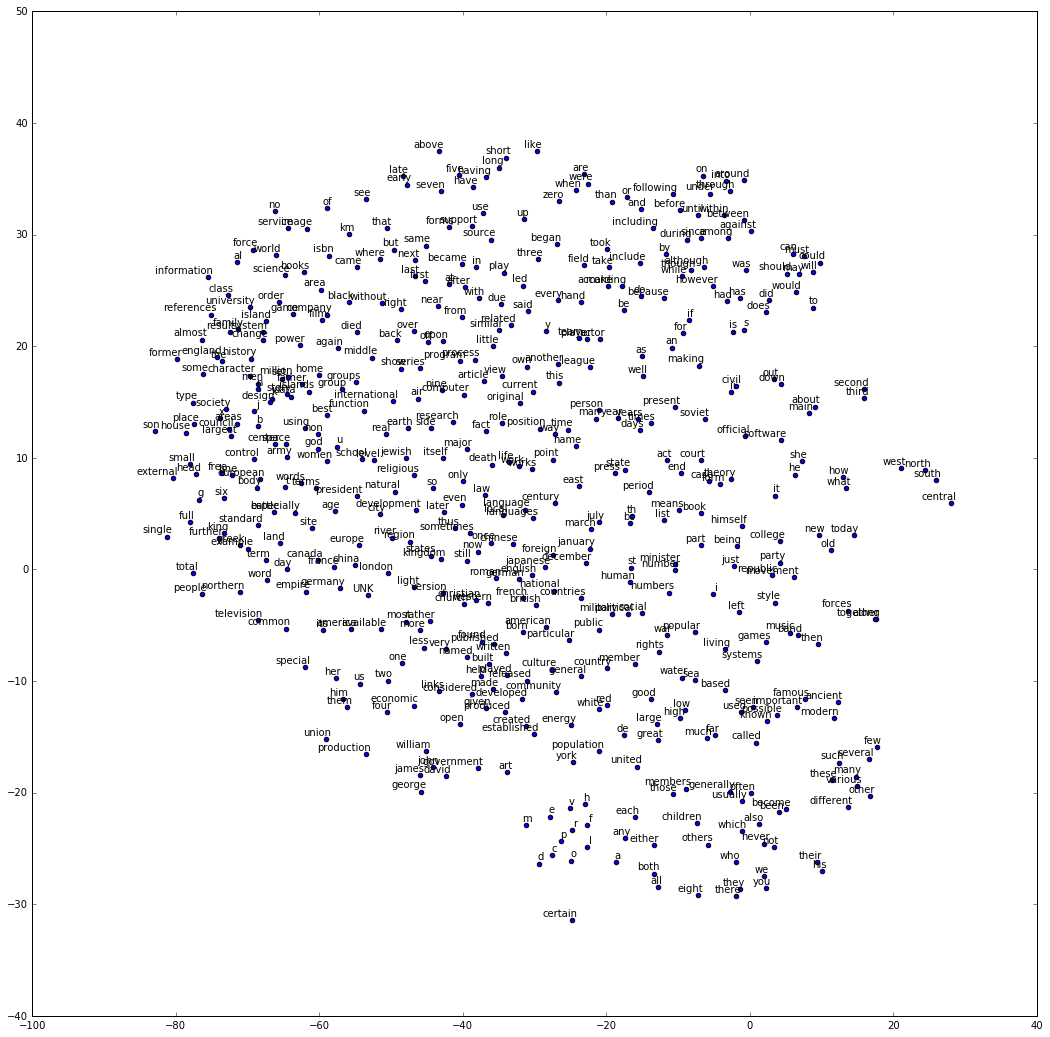

In [11]:
# Step 6: Visualize the embeddings.


def plot_with_labels(low_dim_embs, labels, filename='tsne_jupyter.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")